### Question: How many pieces of trash are on the shores of Swiss lakes and rivers ?

#### The results from the Swiss Litter Report can be used to generate an aproximate number. (very approximate)
#### First we need to make a few assumptions
1. That the results from the SLR are representative of the rest of Switzerland
2. That the data was collected in accordance with the protocol
3. That the maximum density in the results is probably the max that we would find

##### Then we need to import a few librairies from python

In [42]:
import pandas as pd
import numpy as np
import scipy.stats as stats


#### Then we need to get some data:

In [43]:
a = pd.read_csv('csvs_for_db/SLR_Density.csv')

In [44]:
# take a look at the first few rows:
a.iloc[:10]

,location,date,sample,density,quantity
0,Aare_Bern_CaveltiN,2017-04-02,1.0,1.679,47.0
1,Aare_Bern_CaveltiN,2017-05-06,2.0,1.536,43.0
2,Aare_bern_gerberm,2017-04-14,1.0,1.730,154.0
3,Aare_bern_gerberm,2017-05-21,2.0,0.225,20.0
4,Aare_bern_gerberm,2017-06-26,3.0,0.798,71.0
5,Aare_bern_gerberm,2017-07-31,4.0,1.258,112.0
6,Aare_bern_gerberm,2017-08-29,5.0,1.966,175.0
7,Aare_bern_gerberm,2017-09-26,6.0,2.326,207.0
8,Aare_bern_gerberm,2017-10-31,7.0,1.213,108.0
9,Aare_bern_gerberm,2017-11-17,8.0,0.742,66.0


##### Okay that looks good, in this case there is no use for the date, sample number, or quantity.  I will hold on to location and density.

In [45]:
b = a[['location', 'density']].copy()
# if these values are used then the distribution will be skewed right
# which means any calculations from the average and standard deviation will be skewed
# here is an example of how the histogram looks:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Populating the interactive namespace from numpy and matplotlib


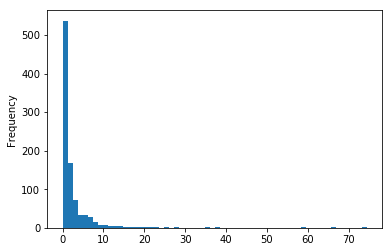

In [46]:
# that import gives a plotting library
% pylab inline
b['density'].plot.hist(stacked=True, bins=60)
plt.show()
# as you can see more than half of the results (over 500) are close to 0 

#### For this to work we need a normal distribution (or something very close), so take the ln of density and see how that works:

In [47]:
# first thing to do is remove the density values = to zero
# there may be alot so we will get see how many samples that are being dropped
c = b['density'].copy() 
d = len(c) # <---- this number tells us how many samples there are before the zero values are dropppe
b = b[b.density > 0]# <---- this gets rid of the zeros
b['log_of'] = np.log(b['density'])# <---- this takes the log of density
e = len(b['log_of'])
f = d-e
print('There were ' + str(d) + ' records to start with ' + str(f) + ' of those were = to zero')

There were 947 records to start with 40 of those were = to zero


In [48]:
# so we are left with 907 records
# check this against the original data 
len(a['density'])

947

#### Ok onwards....

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


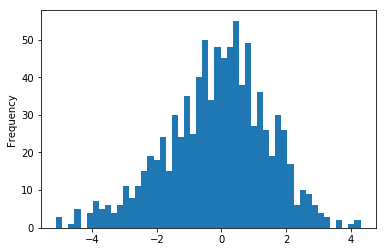

In [49]:
# take a look at the histogram now:
% pylab inline
b['log_of'].plot.hist(stacked=True, bins=50)
plt.show()


#### Ok that is not too bad, see how this fits to a probaiity mass function and a normal curve


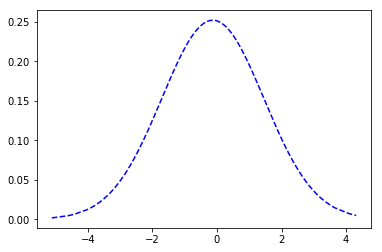

In [50]:
g = list(b['log_of'])
g = sorted(g) #<---- these are the x values 
h = np.mean(g)
i = np.std(g)

freq = [stats.norm.pdf(x, loc=h, scale=i) for x in g] #<---- these are the y values


plt.plot(g, freq, linestyle='dashed', color='b')
plt.show()

#### Okay looking better to summarize up to this point, we have taken the daily quantities as reported by volunteers, divided those by length to get a unit of 'pieces of trash/per meter'.  Then we grouped them according to density (the first chart).  That was skewed right (which is normal for this type of data).
#### Took the natural log of density and did a histogram of that.  At this point it fits a normal distribution.

### Why did we do all that? Because normal distributions are good for this type of calculation
##### Because now we can figure out what the probability is of finding a range of values within given the results of the SLR
##### The chart below makes this more clear

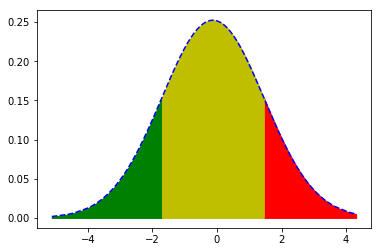

In [51]:
### Take the standard deviation and the average
### ~ 68% of all values fall within one standard deviation(variable i) of the average (variable h)
### so we can add and substract the i from h and define where roughly 68% of the density values lie

sixteenth = h + (-1*i)
thirtytwo = h + i
x = linspace(min(g), max(g), len(g))

plt.plot(g, freq, linestyle='dashed', color='b')
plt.fill_between(x, stats.norm.pdf(x, loc=h, scale=i),where=(x < sixteenth), color='g', alpha=1)
plt.fill_between(x, stats.norm.pdf(x, loc=h, scale=i),where=(x >thirtytwo), color='r', alpha=1)
plt.fill_between(x, stats.norm.pdf(x, loc=h, scale=i),where=(x > sixteenth) & (x <thirtytwo), color='y', alpha=1)
plt.show()

### The yellow section represents roughly 68% of all the reported density values

#### Now all we need to know is how many meters of river and lake shore there are in Switzerland
#### HTTP please https://fr.wikipedia.org/wiki/Hydrologie_de_la_Suisse  this says there are 65'000 kilometers of water ways in switzerland.

In [52]:
# so thee are 1000 meters in a kilometer
meters = 1000 * 65000
# but some of those rivers are way up in the mountains and I heard that there was 40'000 kms
meters_l = 35000 * 1000

### But wait a minute there is a difference between lakes and rivers so we can't use the same distribution for both, we have to reapeat the exercise for both distributions.

In [53]:
# lets sort that out now
# this has the information we need
l_R = pd.read_csv('csvs_for_db/SLR_Beaches.csv')
l_k = l_R[l_R.water == 'lake']
l_r = l_R[l_R.water == 'river']

In [54]:
# now take them out seperateley
lakes = list(l_k['location'])
rivers = list(l_r['location'])
# create a column the original database
b['water'] = 'none'
# reset the index(this has to happen if you want to assign new values in a columnd)
b.reset_index(inplace=True)

In [55]:
# go over these row by row and match location to water type
# then assign the column value
for i, row in b.iterrows():
    if b.loc[i, 'location'] in rivers:
        b.loc[i, 'water'] = 'river'
    if b.loc[i, 'location'] in lakes:
        b.loc[i, 'water'] = 'lake'

In [56]:
# not really necsary but it is neater that way
dfLake = b[b.water == 'lake'].copy()
dfRiver = b[b.water == 'river'].copy()

In [57]:
# get the standard devaition and average from each category

l_log = list(dfLake['log_of'])
r_log = list(dfRiver['log_of'])
r_std, r_mean = np.std(r_log), np.mean(r_log)
l_std, l_mean = np.std(l_log), np.mean(l_log)

In [72]:
lower = (min(r_log) + r_mean)#<---- this is the lower bound of the proposed distribtution 
upper = (max(r_log)-r_mean)/r_std #<---- this is the upper bound of the proposed distribution
l_lower = (min(l_log) + l_mean) #<---- this get as close to zero as possible without messing up the distribution 
l_upper = (max(l_log)-h)/i #<---- this is the upper bound of the proposed distribution

In [73]:
# make some simulated beach lengths
# if we count just the meters and sample 35000000 times into our distribution
# the number will be high---- each value in the orignal list is the average of many meters
# so we want to replicate that ---- as best as we can
aa = np.arange(10, 80, 2, dtype=int)

In [74]:
def take_samples(o,p, high, low, mean, std):
    t = []
    n = 0
    while n < p:
        r = np.random.choice(o)
        #print('this is '+ str(r))
        q = stats.truncnorm.rvs(low, high, loc= mean, scale= std,size=r)
        sub_tot = []
        n += r
        for s in q:
            v = np.exp(s)
            sub_tot.append(v)
        #print(sub_tot)
        t.append(sum(sub_tot))
    #print(n,r)
    return t
r_samps = take_samples(aa, 1000000,upper, lower, r_mean, r_std)
l_samps = take_samples(aa, 1000000,l_upper, l_lower, l_mean, l_std)

In [75]:
sum_r = sum(r_samps).round(0)
sum_l = sum(l_samps).round(0)
print("For every 1'000'000 meters (1k km) of river-bank, you can expect to find " + str(sum_r) + " pieces of trash.")
print("For every 1'000'000 meters (1k km) of lake-shore, you can expect to find " + str(sum_l) + " pieces of trash.")


For every 1'000'000 meters (1k km) of river-bank, you can expect to find 1580335.0 pieces of trash.
For every 1'000'000 meters (1k km) of lake-shore, you can expect to find 873111.0 pieces of trash.


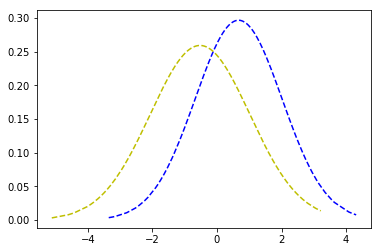

In [62]:
l_sorted = sorted(l_log)
r_sorted = sorted(r_log)

freq_l = [stats.norm.pdf(x, loc=l_mean, scale=l_std) for x in l_sorted] #<---- these are the y values
freq_r = [stats.norm.pdf(x, loc=r_mean, scale=r_std) for x in r_sorted]

plt.plot(l_sorted, freq_l, linestyle='dashed', color='b')
plt.plot(r_sorted, freq_r, linestyle='dashed', color='y')
plt.show()

### Yellow is the river distribution